In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("kushagratandon12/diabetic-retinopathy-balanced")

# print("Path to dataset files:", path)

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import scipy

In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_data = data_gen.flow_from_directory(
    "/workspace/data/train",
    target_size=(380, 380),
    batch_size=32,
    class_mode="categorical"
)

val_data = data_gen.flow_from_directory(
    "/workspace/data/val",
    target_size=(380, 380),
    batch_size=32,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator()

test_data = data_gen.flow_from_directory('/workspace/data/test', target_size=(380,380), class_mode='categorical')

In [ ]:
print(train_data.class_indices)
print(test_data.class_indices)

In [ ]:
# Build the Model

effvb4 = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(380,380, 3))

model = effvb4.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(5, activation="softmax")(model)
model = Model(inputs= effvb4.input, outputs=model)

model.summary()

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime # TensorBoard için

# Modelin zaten tanımlanmış ve oluşturulmuş olduğunu varsayıyoruz (ResNet50)
# model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# model = add_top_layers(model, num_classes) # Kendi eklediğin üst katmanlar

# --- Optimize Edilmiş Compile Ayarları ---

# AdamW için öğrenme oranı ve ağırlık bozunması (weight_decay) başlangıç değerleri
# ResNet50 gibi derin modeller için başlangıç öğrenme oranı genellikle biraz daha yüksek olabilir.
# Ağırlık bozunması, aşırı öğrenmeyi (overfitting) engellemek için önemlidir.
initial_learning_rate = 1e-4 # Genellikle 1e-4 veya 5e-5 ile başlanır

model.compile(
    optimizer=AdamW(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy', # Zatürre ikili sınıflandırma için uygun
    metrics=['accuracy'] # Daha kapsamlı metrikler ekleyebiliriz
)

print(f"Model optimize ediliyor: Learning Rate={initial_learning_rate}")

# --- Optimize Edilmiş Callbacks (Geri Çağrılar) ---

# 1. ReduceLROnPlateau (Öğrenme Oranını Azaltma)
# val_loss'u izlemek yerine val_accuracy'yi izlemek daha mantıklı olabilir,
# çünkü amacımız doğruluk oranını artırmak. Factor ve patience değerleri modelinize göre ayarlanır.
# Çok hızlı düşürmemek için patience'ı biraz artırabiliriz.
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', # val_loss yerine val_accuracy'yi takip et
    mode='max',             # val_accuracy'nin artmasını bekliyoruz
    factor=0.2,             # Öğrenme oranını 0.3 yerine 0.2 ile çarp (daha büyük düşüş)
    patience=5,             # 3 yerine 5 epoch bekle (daha sabırlı)
    verbose=1,
    min_lr=1e-7             # Minimum öğrenme oranını biraz daha düşürebiliriz
)
print(f"ReduceLROnPlateau ayarlandı: Monitor='val_accuracy', Patience={reduce_lr.patience}, Factor={reduce_lr.factor}")


# 2. ModelCheckpoint (Model Kaydetme)
# Val_accuracy'yi izlemek iyi, ancak model.h5 yerine epoch ve accuracy bilgilerini içeren bir isim kullanmak
# farklı denemeleri ayırt etmenizi sağlar. Ayrıca save_weights_only=True de daha hafif dosyalar sağlar.
checkpoint = ModelCheckpoint(
    "resnet50_best_model_{epoch:02d}_{val_accuracy:.4f}.h5", # Model adı dinamik olsun
    monitor="val_accuracy",
    save_best_only=True,
    mode="max", # val_accuracy'nin maksimum değerini kaydet
    verbose=1
)
print(f"ModelCheckpoint ayarlandı: Monitor='val_accuracy', Kayıt formatı='effvb4_best_model_XX_YY.h5'")


# 3. EarlyStopping (Erken Durdurma)
# Aşırı öğrenmeyi engellemek ve zamandan tasarruf etmek için önemli. Patience'ı biraz artırmak iyi olabilir.
earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=8,             # 5 yerine 8 epoch bekle (daha sabırlı, reduce_lr'den biraz daha fazla)
    mode="max",             # val_accuracy'nin artmasını bekliyoruz
    verbose=1,
    restore_best_weights=True # En iyi ağırlıkları geri yükle
)
print(f"EarlyStopping ayarlandı: Monitor='val_accuracy', Patience={earlystop.patience}")

# Tüm callback'leri bir listeye topluyoruz
callbacks_list = [checkpoint, earlystop, reduce_lr]

# Modeli eğitirken bu callback'leri kullanın
# history = model.fit(train_data, epochs=20, batch_size=32,
#                     validation_data=valid_data, verbose=1,
#                     callbacks=callbacks_list)

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data, verbose=1, callbacks=callbacks_list)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Verileri DataFrame'e dönüştürmek için

def grafik_func(history):
    """
    Model eğitim geçmişindeki metrikleri Seaborn kullanarak daha modern bir şekilde çizer.
    Train ve Validation için belirgin renkler ve noktalı yapılar kullanır.
    Metrik yoksa grafik çizmez.

    Args:
        history: Keras'ın model.fit() metodundan dönen history nesnesi.
                 history.history dictionary'sini içermelidir.
    """
    # Seaborn stilini ayarla
    sns.set_style("whitegrid") # Beyaz ızgara arka planı

    # Manuel renk paleti oluştur (Train ve Validation için belirgin renkler)
    # Train için genellikle mavi tonları, Validation için turuncu/kırmızı tonları tercih edilir.
    colors = {
        'Train': 'blue',    # Koyu bir mavi
        'Validation': 'red' # Kırmızı, çok daha belirgin
    }

    # Metrik listesi: her biri için ayrı grafik çizilecek
    metric_pairs = [
        ("accuracy", "Accuracy"),
        ("loss", "Loss"),
        ("precision", "Precision"),
        ("recall", "Recall")
    ]

    for metric_name, display_name in metric_pairs:
        train_metric_key = metric_name
        val_metric_key = f"val_{metric_name}"

        # Metriklerin history objesinde olup olmadığını kontrol et
        if train_metric_key in history.history and val_metric_key in history.history:
            # Verileri DataFrame'e dönüştürerek Seaborn için uygun hale getir
            epochs = range(1, len(history.history[train_metric_key]) + 1)
            data = {
                'Epochs': list(epochs),
                'Value': history.history[train_metric_key] + history.history[val_metric_key],
                'Type': [f'Train {display_name}'] * len(epochs) + [f'Validation {display_name}'] * len(epochs)
            }
            df_train_val = pd.DataFrame({
                'Epochs': epochs,
                f'Train {display_name}': history.history[train_metric_key],
                f'Validation {display_name}': history.history[val_metric_key]
            })

            plt.figure(figsize=(10, 6)) # Grafik boyutunu ayarla

            # Seaborn lineplot kullanarak çizim yap
            # Her bir çizgi için farklı renk ve marker belirttik
            sns.lineplot(x='Epochs', y=f'Train {display_name}', data=df_train_val,
                         label=f'Train {display_name}', color=colors['Train'],
                         marker='o', markersize=6, linewidth=2) # 'o' daire marker, 's' kare, '^' üçgen
            sns.lineplot(x='Epochs', y=f'Validation {display_name}', data=df_train_val,
                         label=f'Validation {display_name}', color=colors['Validation'],
                         marker='X', markersize=7, linewidth=2) # 'X' çarpı marker

            plt.xlabel("Epochs", fontsize=12) # Etiket font boyutunu ayarla
            plt.ylabel(display_name, fontsize=12)
            plt.title(f"Model {display_name} Over Epochs", fontsize=14, fontweight='bold') # Başlık fontunu ayarla
            plt.legend(fontsize=10) # Lejant fontunu ayarla
            plt.grid(True, linestyle='--', alpha=0.7) # Izgarayı daha belirgin hale getir
            plt.tight_layout() # Düzenleme için boşlukları otomatik ayarla
            plt.show()
        else:
            print(f"⚠️ '{metric_name}' veya 'val_{metric_name}' bulunamadı, bu metrik için grafik çizilemedi.")

In [ ]:
grafik_func(history)

# Predict Bölümü

In [ ]:
import kagglehub
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy


test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    "/workspace/data/test",
    target_size=(380, 380),
    batch_size=32,
    class_mode="categorical"
)

print(test_data.class_indices)

model = load_model("effvb4_best_model_02_0.5784.h5")

loss, accuracy = model.evaluate(test_data)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

1/1 [==============================] - 0s 171ms/step


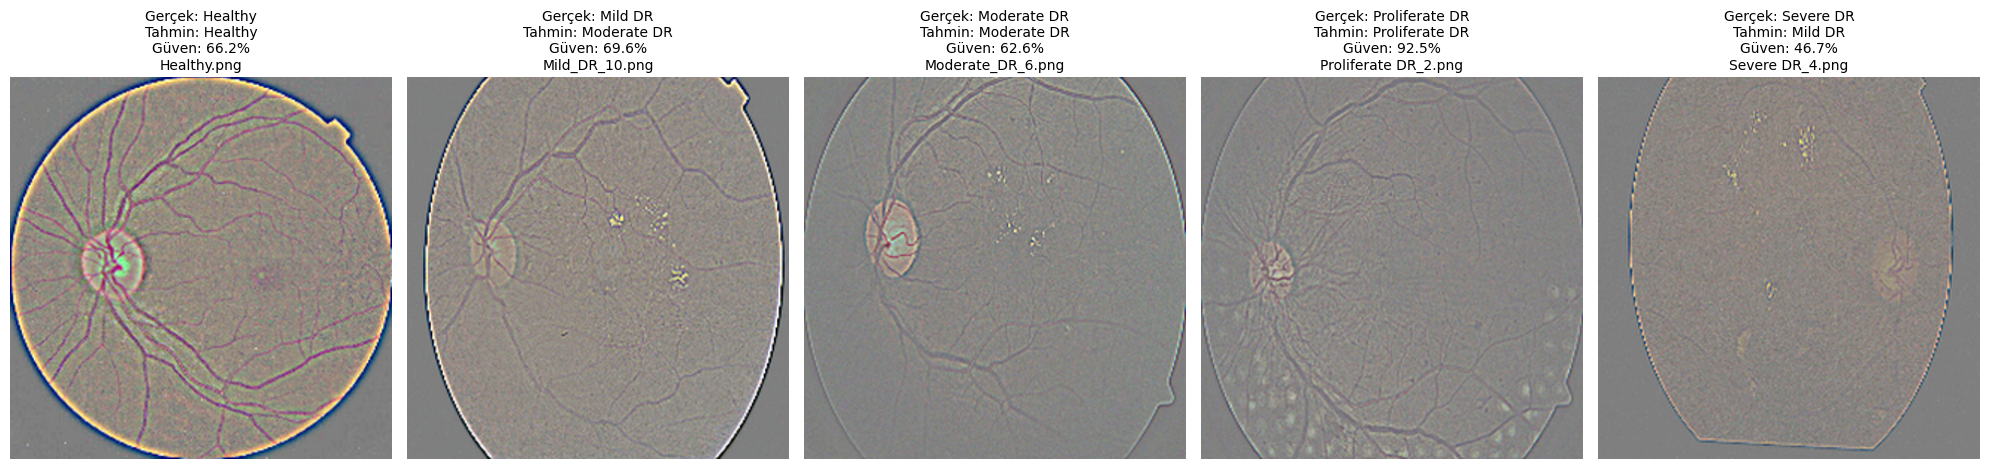

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image, UnidentifiedImageError

# Sınıf isimleri
class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']

def get_random_image_per_class(data_dir):
    """Her sınıf klasöründen rastgele bir görsel seçer."""
    samples = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not image_files:
            continue
        random_img = random.choice(image_files)
        full_path = os.path.join(class_dir, random_img)
        samples.append((full_path, class_name))
    return samples

def predict_and_visualize(samples, model_path):
    """Görselleri tahmin et ve yan yana göster."""
    model = load_model(model_path)

    plt.figure(figsize=(20, 5))
    for i, (img_path, true_class) in enumerate(samples):
        try:
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize((380, 380))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array)
            predicted_index = np.argmax(prediction)
            confidence = np.max(prediction) * 100
            predicted_label = class_names[predicted_index]

            # Görselleştirme
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(img_resized)
            plt.axis("off")
            plt.title(f"Gerçek: {true_class}\nTahmin: {predicted_label}\nGüven: {confidence:.1f}%\n{os.path.basename(img_path)}",
                      fontsize=10)

        except UnidentifiedImageError:
            print(f"Hatalı görsel atlandı: {img_path}")
            continue

    plt.tight_layout()
    plt.show()

# Kullanım
data_dir = r"C:\Users\Batu\Documents\MediAInV1\models\effvb4\data"
model_path = "effvb4_best_model_05_0.5913.h5"

samples = get_random_image_per_class(data_dir)
predict_and_visualize(samples, model_path)